In [1042]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Note: This file is currently in progress and large portions are unfinished.
Thesis:
If 2+ assets are correlated, then when yesterday's returns differ from the predicted relationship (OLS or multivariate) we can long/short a pair to have a statistically significant edge.

In [1043]:
benchmark = 'BTC-USD'

tickers = ['BTC-USD', 'ARKB']
start_ts = '2024-01-01' # SEC approves first btc ETFs in jan 2024

data = yf.download(tickers=tickers, start=start_ts, auto_adjust=False)

px = data['Adj Close']
ret = px.pct_change(1, fill_method=None).dropna() 


[*********************100%***********************]  2 of 2 completed


Correlation

In [1044]:
ret['BTC-USD'].corr(ret['ARKB'])

0.8574459667952546

In [1045]:
ret.head()

Ticker,ARKB,BTC-USD
Date,,
2024-01-12,-0.062019,-0.075815
2024-01-17,-0.014939,-0.009554
2024-01-18,-0.044564,-0.034640
2024-01-19,0.019048,0.008636
2024-01-23,-0.024499,0.008560


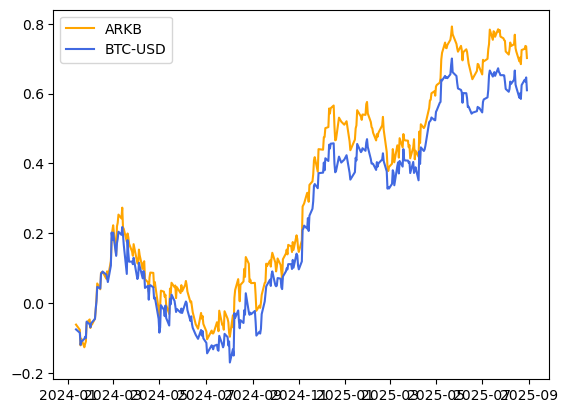

In [1046]:
plt.plot(ret.iloc[:,0].cumsum(), color = 'orange', label = ret.columns[0])
plt.plot(ret.iloc[:,1].cumsum(), color = 'royalblue', label = ret.columns[1])
plt.legend()
plt.show()

Testing Hypothesis

<Axes: xlabel='Date'>

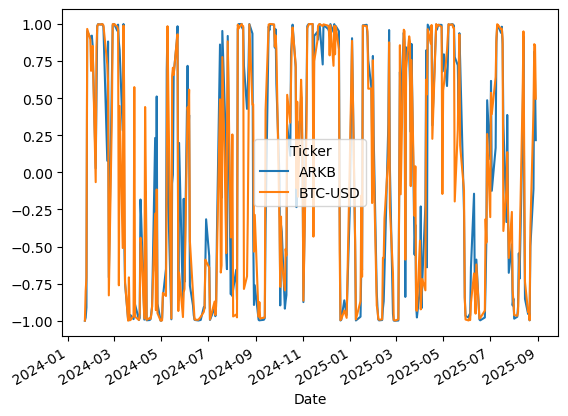

In [1047]:
# rolling weekly gains, should window be 5 or 7? Probably 5 because ETFs only trade 5 days a week, also use tanh to transform to [-1,1]

# First transform to z-score, save std
ret_std = ret.std()
ret = ret.subtract(ret.mean())
ret = ret.div(ret_std)

weekly_ret = np.tanh(ret.rolling(5).sum())
weekly_ret.plot()

In [1048]:
X_train, X_test, y_train, y_test = train_test_split(weekly_ret.iloc[:,0], weekly_ret.iloc[:,1], test_size=0.2, random_state=42)
# Train mask
train_mask = ~np.isnan(X_train) & ~np.isnan(y_train)
X_train = np.array(X_train).reshape(-1, 1)[train_mask]
y_train = np.array(y_train)[train_mask]

# Test mask
test_mask = ~np.isnan(X_test) & ~np.isnan(y_test)
X_test = np.array(X_test).reshape(-1, 1)[test_mask]
y_test = np.array(y_test)[test_mask]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

std = y_pred.std()


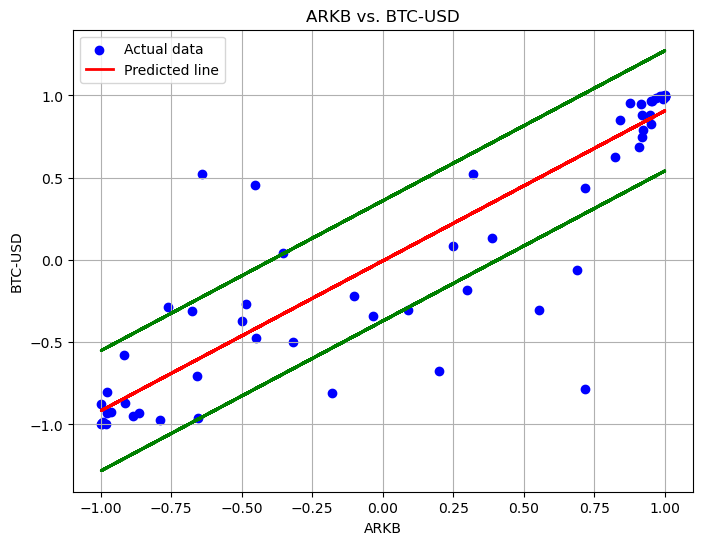

In [1049]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted line')
plt.plot(X_test, y_pred + 0.5*std, color='green', linewidth=2)
plt.plot(X_test, y_pred - 0.5*std, color='green', linewidth=2)
plt.xlabel(weekly_ret.columns[0])
plt.ylabel(weekly_ret.columns[1])
plt.title(f'{weekly_ret.columns[0]} vs. {weekly_ret.columns[1]}')
plt.legend()
plt.grid(True)
plt.show()

Implementation

In [1050]:
def corr_backtest(px, ret, starting_cash=1e4):
    """
    Backtest pairs strategy: signal based on yesterday's residual.
    If yesterday's residual > +1 std → short X, long Y
    If yesterday's residual < -1 std → long X, short Y
    """
    x_col, y_col = ret.columns[0], ret.columns[1]
    
    # Align series and drop missing values
    series_x = ret[x_col].dropna()
    series_y = ret[y_col].reindex(series_x.index).dropna()
    prices_x = px[x_col].reindex(series_x.index).dropna()
    prices_y = px[y_col].reindex(series_y.index).dropna()
    
    # Fit regression y ~ x
    model = LinearRegression()
    X = series_x.values.reshape(-1, 1)
    y = series_y.values
    model.fit(X, y)
    y_pred = model.predict(X)
    
    residuals = series_y.values - y_pred
    std = residuals.std()
    
    # Shift by 1 day: today's signal comes from yesterday's residual
    signals = np.where(pd.Series(residuals).shift(1) > std, -1, 0)   # residual high → short X / long Y
    signals = np.where(pd.Series(residuals).shift(1) < -std, 1, signals)  # residual low → long X / short Y
    signals = pd.Series(signals, index=series_y.index)
    
    # Track portfolio
    port_val = [starting_cash]
    positions = [0]  # -1 = short X/long Y, +1 = long X/short Y, 0 = flat
    trades = [0]
    trade_records = []
    entry_date, entry_px_x, entry_px_y, entry_pos = None, None, None, None
    
    for i in range(1, len(series_y)):
        pos_prev = positions[-1] # look at yesterdays rets
        pos_new = signals.iloc[i]
        trade = pos_new - pos_prev
        
        # detect trade entry/exit
        if trade != 0:
            if pos_prev == 0 and pos_new != 0:  # entering position
                entry_date = series_y.index[i]
                entry_px_x = prices_x.iloc[i]
                entry_px_y = prices_y.iloc[i]
                entry_pos = pos_new
            elif pos_prev != 0 and pos_new == 0:  # exiting position
                exit_date = series_y.index[i]
                exit_px_x = prices_x.iloc[i]
                exit_px_y = prices_y.iloc[i]
                
                if entry_pos == -1:  # short X, long Y
                    pnl = (exit_px_y - entry_px_y) - (exit_px_x - entry_px_x)
                elif entry_pos == 1:  # long X, short Y
                    pnl = (exit_px_x - entry_px_x) - (exit_px_y - entry_px_y)
                
                trade_records.append({
                    "EntryDate": entry_date,
                    "ExitDate": exit_date,
                    "HoldingTime": (exit_date - entry_date).days,
                    "Position": f"Short {x_col} / Long {y_col}" if entry_pos == -1 else f"Long {x_col} / Short {y_col}",
                    f"EntryPrice_{x_col}": entry_px_x,
                    f"EntryPrice_{y_col}": entry_px_y,
                    f"ExitPrice_{x_col}": exit_px_x,
                    f"ExitPrice_{y_col}": exit_px_y,
                    "PnL": pnl,
                    "Return%": pnl / starting_cash * 100
                })
        
        if pos_prev == -1:  # short X, long Y
            pnl_step = ((prices_y.iloc[i] - prices_y.iloc[i-1]) -
                        (prices_x.iloc[i] - prices_x.iloc[i-1]))
        elif pos_prev == 1:  # long X, short Y
            pnl_step = ((prices_x.iloc[i] - prices_x.iloc[i-1]) -
                        (prices_y.iloc[i] - prices_y.iloc[i-1]))
        else:
            pnl_step = 0
        
        port_val.append(port_val[-1] + pnl_step)
        positions.append(pos_new)
        trades.append(trade)
    
    results = pd.DataFrame({
        f"Return_{x_col}": series_x,
        f"Return_{y_col}": series_y,
        "Predicted": y_pred,
        "Residual": residuals,
        "Signal": signals,
        "Position": positions,
        "Trades": trades,
        "Portfolio": port_val 
    }, index=series_y.index)
    
    trades_df = pd.DataFrame(trade_records)
    return results, trades_df


In [1051]:
port, trades = corr_backtest(px, ret)


In [1052]:
port.head() # negative values in Portfolio represent short positions

,Return_ARKB,Return_BTC-USD,Predicted,Residual,Signal,Position,Trades,Portfolio
Date,,,,,,,,
2024-01-12,-2.203957,-2.778090,-1.889774,-0.888316,0,0,0,10000.000000
2024-01-17,-0.588542,-0.410121,-0.504643,0.094522,1,1,1,10000.000000
2024-01-18,-1.605032,-1.306619,-1.376228,0.069609,0,0,-1,11479.957083
2024-01-19,0.577620,0.239936,0.495278,-0.255342,0,0,0,11479.957083
2024-01-23,-0.916581,0.237213,-0.785919,1.023132,0,0,0,11479.957083


Performance Metrics

Strong SR (3.6) that indicates solid performance and risk management. We also outperform buy/hold of BTC-USD which is important for this strategy since our positions will be quite concentrated in only a few tokens.

In [1053]:
# sortino ratio if interested, swap denominator below
neg_trades_mask = trades['PnL'] < 0
neg_trades = trades['PnL'][neg_trades_mask]
neg_std = neg_trades.std()

SR = trades['PnL'].mean() / trades['PnL'].std() * np.sqrt(252)
SR

3.6869466837645546

In [1054]:
starting_cash = 1e4
portfolio_value = starting_cash + trades['PnL'].cumsum() 
total_return_strat = (portfolio_value.iloc[-1] / starting_cash) - 1
print(total_return_strat)

btc_hold= px['BTC-USD'][-1]/px['BTC-USD'][0]
print(btc_hold)



2.867882036781311
2.4609865694535085


/var/folders/29/w4tcnlg50y96jwdwn1pw0r640000gn/T/ipykernel_57609/2263289608.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_hold= px['BTC-USD'][-1]/px['BTC-USD'][0]


In [1055]:
trades['PnL'].cumsum().iloc[-1] # sanity check

28678.82036781311

<Axes: >

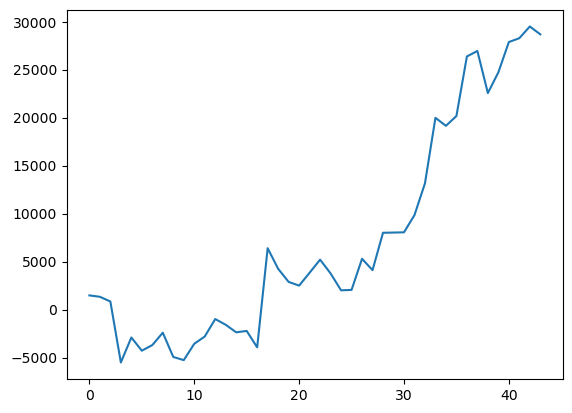

In [1056]:
trades['PnL'].cumsum().plot()
# x-axis is trade number (ID)

In [1057]:
import statsmodels.api as sm

btc_ret = {}
# for computing returns over a specifc date range
for i in range(len(trades)):
    trade = trades.iloc[i]
    ht = trade['HoldingTime']
    end_date = trade['ExitDate']
    start_date = trade['EntryDate']
    ht_change = (px[benchmark].loc[end_date] - px[benchmark].loc[start_date]) / np.abs(px[benchmark].loc[start_date])
    btc_ret[end_date] = ht_change
btc_ret = pd.Series(btc_ret).to_frame()
btc_ret = btc_ret.rename(columns = {0:'BTC-USD'})

In [1058]:
strategy_ret = trades.set_index("ExitDate")['Return%'].dropna() / 100 # whoops, forgot that I'd already multiplied by 100
# align with btc_ret 
strategy_ret, benchmark_ret = strategy_ret.align(btc_ret, join="inner")

X = sm.add_constant(benchmark_ret)

#regression
model = sm.OLS(strategy_ret, X).fit()

print(model.summary())

# extract alpha and beta
alpha = model.params['const'] 
beta = model.params['BTC-USD'] 
print(f"Alpha: {alpha}, Beta: {beta}")


                            OLS Regression Results                            
Dep. Variable:                Return%   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     13.51
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           0.000667
Time:                        19:28:59   Log-Likelihood:                0.11984
No. Observations:                  44   AIC:                             3.760
Df Residuals:                      42   BIC:                             7.329
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0725      0.037      1.944      0.0

Interpretation

We find that that we are on the cusp of statistical significance for alpha so further work is needed to confirm the presence of true alpha. Also of note is the R^2 of 0.24. This tells us that we are perhaps not fully uncorrelated with BTC-USD. This is confirmed below. 

That being said, the SR is very high (3.6), and the sortino is even higher. This indicates promise that this strategy could be viable for trading. Next steps include factoring in trading costs and trying to better understand the edge, why does this even exist in the first place?

In [1059]:
strategy_ret.corr(benchmark_ret['BTC-USD'])


-0.4933669164616321

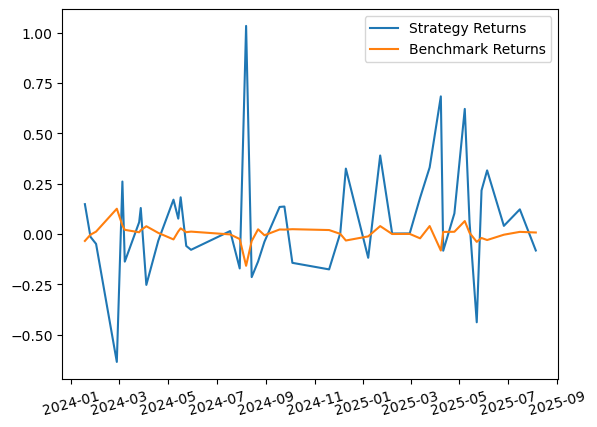

In [1060]:
plt.plot(strategy_ret, label = 'Strategy Returns')
plt.plot(benchmark_ret, label = 'Benchmark Returns')
plt.xticks(rotation=15)
plt.legend()
plt.show()

Lets assume that each trade experiences 7 bps (0.0007) of slippage. Then, each of our trades experiences 28 bps of slippage since we place two (short/long) orders on entry and 2 on exit.

In [1061]:
ret_pct = trades['Return%'].mean() - 0.0028 * len(trades)
new_SR = ret_pct / trades['Return%'].std() * np.sqrt(252)
new_SR

3.6172569255143103

In [1062]:
strategy_ret_df = pd.Series(strategy_ret).to_frame()
benchmark_ret_df = pd.Series(benchmark_ret['BTC-USD']).to_frame()
excess_ret = strategy_ret_df['Return%'] - benchmark_ret_df['BTC-USD'] - 0.0120
IR = excess_ret.mean() / excess_ret.std() # daily IR, annualize to 252
IR * np.sqrt(252)

2.675975452709037

Sharpe ratio drops but not terribly (was 3.686). IR is extremely high, could be valuable in trading.